# Cálculo de energía del gradiente

In [7]:
using DataFrames
using Gadfly
using Cairo
using MIToS.PDB
using Chemfiles
using Distributions
set_default_plot_size(40cm, 14cm)

In [8]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [9]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [10]:
function read_ptraj_modes(file, modes_elements, norma::Bool=true)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [11]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

In [12]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        temp_bool = (in_vec .>= in_bins[i]) & (in_vec .< in_bins[i+1])
        out_counts[i] = sum(in_weight[temp_bool])
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [30]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann y temperatura.
    KB = 1.38064852e-23
    T = 300
    
    # Obtengo la 1era y 2da parte de la ecuación
    pri = d^2 * KB * T / 2
    
    sec = sum(evals .* gdte.^2)

    return pri * sec
end

energia_gdte (generic function with 2 methods)

# Energía

In [ ]:
# Preparo variables
points = 21
max = floor(points / 2)
min = -max
main_dir = "/home/german/labo/16/exs/"

### 1hvr_apo

In [108]:
pdb_1hvr_apo = read(string(main_dir, "cavities/bu/avg_1hvr_apo.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_apo = length(pdb_1hvr_apo)
aa3_1hvr_apo = aa_1hvr_apo * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_apo, evals_1hvr_apo = read_ptraj_modes(string(main_dir, "run/1hvr_apo/pca/modes_1hvr_apo"),
                                    aa3_1hvr_apo);

# Leo gradiente
df_gdte_whole_1hvr_apo = readtable(string(main_dir, "paper/misc/gdte_1hvr_apo"))
gdte_whole_1hvr_apo = convert(Array{Float64,1 }, df_gdte_whole_1hvr_apo[:delta]);

# Obtengo barrido de energías
E_1hvr_apo = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    E_1hvr_apo[i] = energia_gdte(evals_1hvr_apo, gdte_whole_1hvr_apo, d)
end

### 1hvr_hol

In [109]:
pdb_1hvr_hol = read(string(main_dir, "cavities/bu/avg_1hvr_hol.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1hvr_hol = length(pdb_1hvr_hol)
aa3_1hvr_hol = aa_1hvr_hol * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1hvr_hol, evals_1hvr_hol = read_ptraj_modes(string(main_dir, "run/1hvr_hol/pca/modes_1hvr_hol"),
                                    aa3_1hvr_hol);

# Leo gradiente
df_gdte_whole_1hvr_hol = readtable(string(main_dir, "paper/misc/gdte_1hvr_hol"))
gdte_whole_1hvr_hol = convert(Array{Float64,1 }, df_gdte_whole_1hvr_hol[:delta]);

# Obtengo barrido de energías
E_1hvr_hol = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    E_1hvr_hol[i] = energia_gdte(evals_1hvr_hol, gdte_whole_1hvr_hol, d)
end

### 1m14

In [110]:
pdb_1m14 = read(string(main_dir, "run/1m14/pca/cut_avg_1m14.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_1m14 = length(pdb_1m14)
aa3_1m14 = aa_1m14 * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_1m14, evals_1m14 = read_ptraj_modes(string(main_dir, "run/1m14/pca/modes_1m14"),
                                    aa3_1m14);

# Leo gradiente
df_gdte_whole_1m14 = readtable(string(main_dir, "paper/misc/gdte_1m14"))
gdte_whole_1m14 = convert(Array{Float64,1 }, df_gdte_whole_1m14[:delta]);

# Obtengo barrido de energías
E_1m14 = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    E_1m14[i] = energia_gdte(evals_1m14, gdte_whole_1m14, d)
end

### 256l

In [112]:
pdb_256l = read(string(main_dir, "run/256l/pca/cut_avg_256l.pdb"), PDBFile, group="ATOM");

# Obtengo el nro de aa's
aa_256l = length(pdb_256l)
aa3_256l = aa_256l * 3

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_256l, evals_256l = read_ptraj_modes(string(main_dir, "run/256l/pca/modes_256l"),
                                    aa3_256l);

# Leo gradiente
df_gdte_whole_256l = readtable(string(main_dir, "paper/misc/gdte_256l"))
gdte_whole_256l = convert(Array{Float64,1 }, df_gdte_whole_256l[:delta]);

# Obtengo barrido de energías
E_256l = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    E_256l[i] = energia_gdte(evals_256l, gdte_whole_256l, d)
end

## Plots

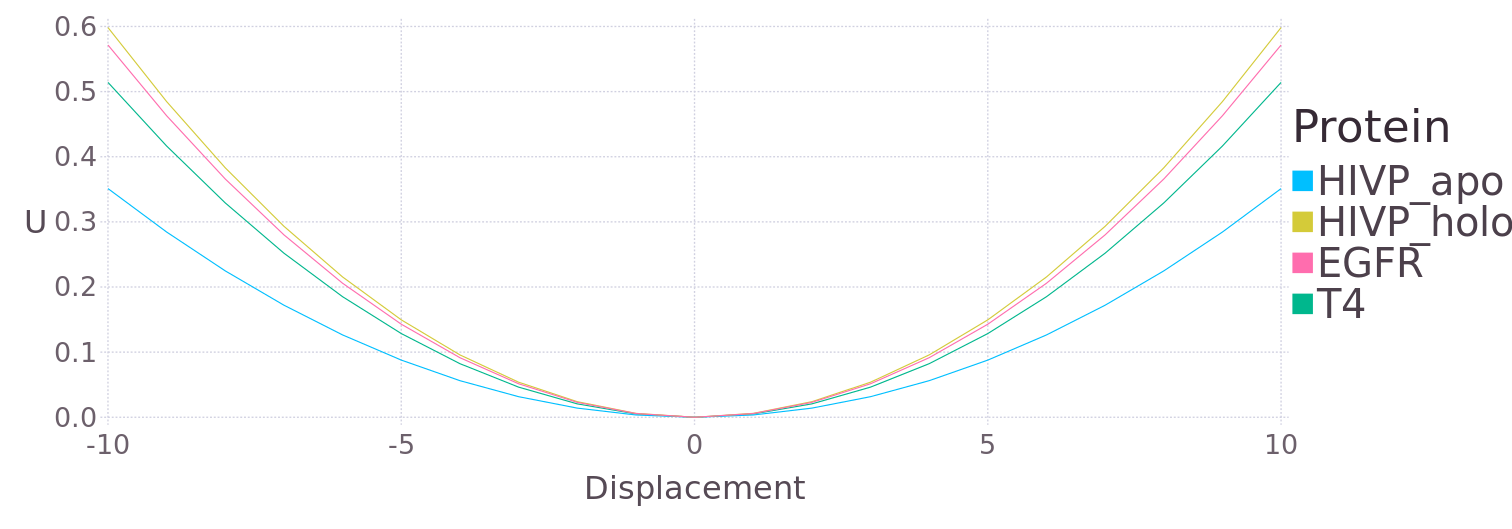

In [115]:
# Compilo en un dataframe.
df_E = DataFrame(U = [ E_1hvr_apo ; E_1hvr_hol ; E_1m14 ; E_256l ] ./ 1e-16,
Displacement = repeat(collect(min:1:max), outer = [4]), 
Protein = repeat(["HIVP_apo" ; "HIVP_holo" ; "EGFR" ; "T4"], inner = [points]))


pdf_E = plot(df_E, y = "U", x = "Displacement", Geom.line, color = "Protein",
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

## Guardo plots

In [116]:
out_filename_5_fig = string(main_dir, "paper/5-fig/5a-fig.png")
draw(PNG(out_filename_5_fig, 120cm, 40cm), pdf_E)